# 1Epochs/static="features" Explore the predictions of runoff model

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/jovyan/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from typing import List, Union, Optional, Tuple, Dict

data_dir = Path('data/')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')
# data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/')
# plot_dir = Path('/Users/tommylees/Downloads')

assert data_dir.exists()

In [3]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data

In [73]:
EXPERIMENT =      'one_timestep_forecast_1epoch'
TRUE_EXPERIMENT = 'one_timestep_forecast'
TARGET_VAR =      'discharge_vol'

assert (data_dir / f"models/{EXPERIMENT}").exists()
assert (data_dir / f"features/{TRUE_EXPERIMENT}").exists()

# Read in the data

In [74]:
lstm_pred = read_pred_data('rnn', data_dir, experiment=EXPERIMENT)
lstm_pred = lstm_pred.rename({'spatial_unit': 'station_id'})
lstm_pred

Reading all .nc files from: data/models/one_timestep_forecast_1epoch/rnn
All datasets loaded. Now combining ...


<xarray.Dataset>
Dimensions:     (station_id: 667, time: 1734)
Coordinates:
  * station_id  (station_id) object '10002' '10003' '1001' ... '96004' '97002'
  * time        (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2015-09-30
Data variables:
    preds       (time, station_id) float32 17.427685 22.372772 ... 2.434773

[<matplotlib.lines.Line2D at 0x7f8024a12a50>]

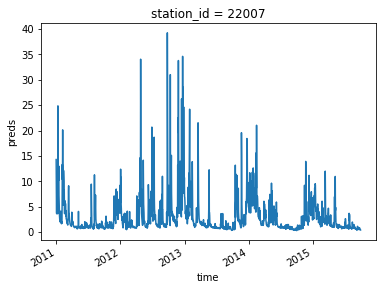

In [12]:
fig, ax = plt.subplots()
lstm_pred.preds.isel(station_id=0).plot(ax=ax)

# Read in the True data

In [78]:
ds = xr.open_dataset(data_dir / 'interim__/camels_preprocessed/data.nc')

# get the times that match
min_time = lstm_pred.time.min().values
max_time = lstm_pred.time.max().values
y_test = ds.discharge_vol.sel(time=slice(min_time, max_time))

In [79]:
y_test

<xarray.DataArray 'discharge_vol' (time: 1734, station_id: 671)>
[1163514 values with dtype=float64]
Coordinates:
  * station_id  (station_id) object '55008' '54027' '102001' ... '54095' '97002'
  * time        (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2015-09-30

In [80]:
# get the stations that match
y_test = y_test.sel(
    station_id=y_test.station_id[
        np.isin(y_test.station_id, lstm_pred.station_id)
    ]
)

In [81]:
y_test

<xarray.DataArray 'discharge_vol' (time: 1734, station_id: 667)>
[1156578 values with dtype=float64]
Coordinates:
  * station_id  (station_id) object '54027' '102001' '72005' ... '54095' '97002'
  * time        (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2015-09-30

# compare performance

In [126]:
from src.analysis.evaluation import (r2_score, rmse, spatial_rmse, spatial_r2, spatial_nse) 
from src.analysis.evaluation import temporal_rmse, temporal_r2, temporal_nse

In [127]:
# calculate performance for each station (collapse time)
rmse_da = spatial_rmse(y_test, lstm_pred.preds)
r2_da = spatial_r2(y_test, lstm_pred.preds)
nse_da = spatial_nse(y_test, lstm_pred.preds)

In [128]:
# calculate performance for each station (collapse space)
rmse_time = temporal_rmse(y_test, lstm_pred.preds)
r2_time = temporal_r2(y_test, lstm_pred.preds)
nse_time = temporal_nse(y_test, lstm_pred.preds)

In [85]:
print(lstm_pred.preds.shape)
print(y_test.shape)

(1734, 667)
(1734, 667)


In [86]:
true_da = y_test
pred_da = lstm_pred.preds

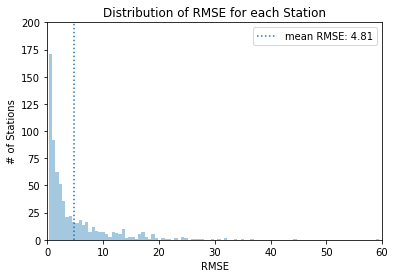

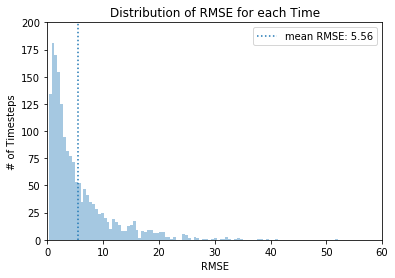

In [91]:
xlim = [0, 60]
ylim = [0, 200]

fig, ax = plt.subplots()
sns.distplot(rmse_da.values, ax=ax, kde=False, bins=100)
ax.set_title('Distribution of RMSE for each Station')
ax.set_ylabel('# of Stations')
ax.set_xlabel('RMSE');
ax.axvline(rmse_da.mean(), ls=":", label=f'mean RMSE: {rmse_da.mean().values:.2f}')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.legend()

fig, ax = plt.subplots()
sns.distplot(rmse_time.values, ax=ax, kde=False, bins=100)
ax.set_title('Distribution of RMSE for each Time')
ax.set_ylabel('# of Timesteps')
ax.set_xlabel('RMSE');
ax.axvline(rmse_time.mean(), ls=":", label=f'mean RMSE: {rmse_time.mean().values:.2f}')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.legend()

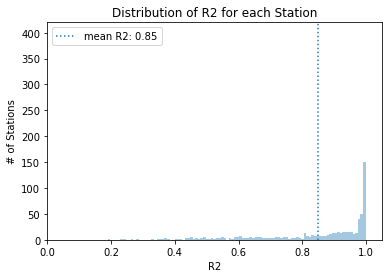

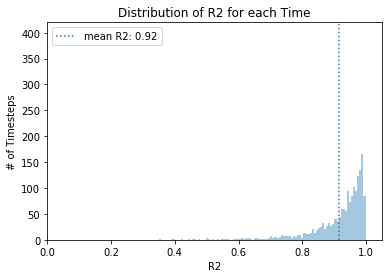

In [93]:
xlim = [0, 1.05]
ylim = [0, 420]

fig, ax = plt.subplots()
sns.distplot(r2_da.values, ax=ax, kde=False, bins=100)
ax.set_title('Distribution of R2 for each Station')
ax.set_ylabel('# of Stations')
ax.set_xlabel('R2');
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.axvline(r2_da.mean(), ls=":", label=f'mean R2: {r2_da.mean().values:.2f}')
plt.legend()


fig, ax = plt.subplots()
sns.distplot(r2_time.values, ax=ax, kde=False, bins=100)
ax.set_title('Distribution of R2 for each Time')
ax.set_ylabel('# of Timesteps')
ax.set_xlabel('R2');
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.axvline(r2_time.mean(), ls=":", label=f'mean R2: {r2_time.mean().values:.2f}')
plt.legend()


Text(0.5, 1.0, 'Moving 3M Performance [RMSE]')

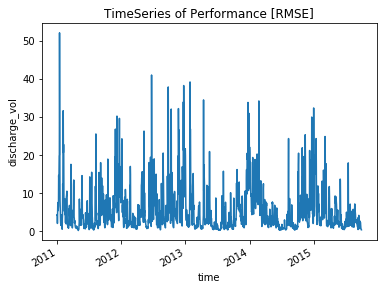

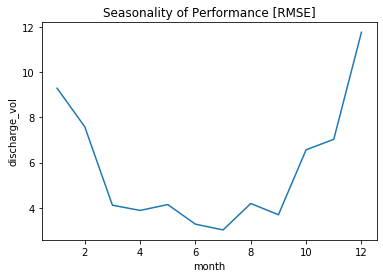

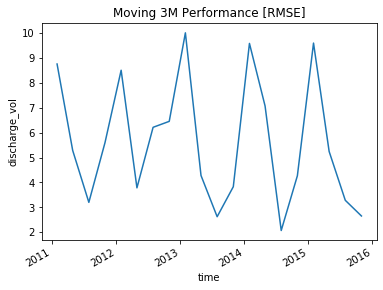

In [94]:
fig, ax = plt.subplots()
rmse_time.plot(ax=ax)
ax.set_title('TimeSeries of Performance [RMSE]')

fig, ax = plt.subplots()
rmse_time.groupby('time.month').mean().plot(ax=ax)
ax.set_title('Seasonality of Performance [RMSE]')

fig, ax = plt.subplots()
rmse_time.resample(time='3M').mean().plot(ax=ax)
ax.set_title('Moving 3M Performance [RMSE]')

Text(0.5, 1.0, 'Moving 3M Performance [R2]')

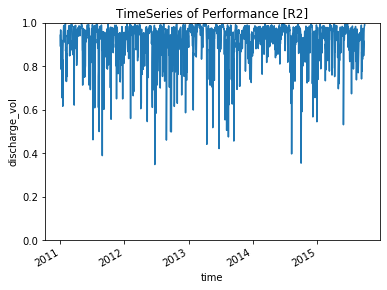

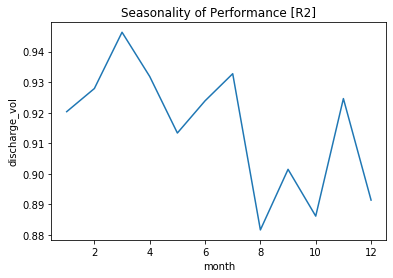

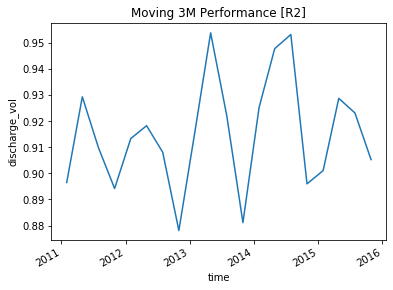

In [95]:
fig, ax = plt.subplots()
r2_time.plot(ax=ax)
ax.set_title('TimeSeries of Performance [R2]')
ax.set_ylim(0, 1)

fig, ax = plt.subplots()
r2_time.groupby('time.month').mean().plot(ax=ax)
ax.set_title('Seasonality of Performance [R2]')

fig, ax = plt.subplots()
r2_time.resample(time='3M').mean().plot(ax=ax)
ax.set_title('Moving 3M Performance [R2]')


In [96]:
from src.analysis.evaluation import join_true_pred_da

In [97]:
df = (
    join_true_pred_da(true_da, pred_da)
    .to_dataframe()
    .reset_index()
    .set_index('time')
)
df.head()

,station_id,discharge_vol,preds
time,,,
2011-01-01,10002,13.77,17.427685
2011-01-02,10002,10.40,13.491203
2011-01-03,10002,12.15,9.695284
2011-01-04,10002,12.52,18.241283
2011-01-05,10002,10.11,13.901167


In [129]:
# rmse and r2 df
metrics_df = rmse_da.to_dataframe().drop(columns='time').rename(columns={"preds": "rmse"}).join(
    r2_da.to_dataframe().drop(columns='time').rename(columns={"preds": "r2"})
)
metrics_df = metrics_df.join(
    nse_da.to_dataframe().rename(columns={"preds": "nse"})
)

metrics_df = metrics_df.reset_index()
metrics_df.head()

,station_id,rmse,r2,nse
0,10002,2.131086,0.865936,0.776408
1,10003,2.434961,0.849426,0.846662
2,1001,2.004691,0.909865,0.707299
3,101002,0.702998,0.992391,-1.849979
4,101005,0.683455,0.993042,-2.089076


## Compare with the 20 epochs / static="features" model

AttributeError: 'DataFrame' object has no attribute 'nse'

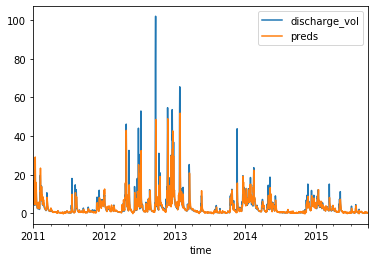

In [125]:
test_stations = ['22007', '27049', '28018', '31021', '31023', '34004', '35003', '39022', '41029', '51001', '55025', '57004', '83010']

for station_id in test_stations:
    fig, ax = plt.subplots()
    df.query(f"station_id == '{station_id}'").drop(columns='station_id').plot(ax=ax)
    rmse_val = metrics_df.query(f"station_id == '{station_id}'").rmse.values[0]
    r2_val = metrics_df.query(f"station_id == '{station_id}'").r2.values[0]
    nse_val = metrics_df.query(f"station_id == '{station_id}'").nse.values[0]
    ax.set_title(f"{station_id}\nRMSE: {rmse_val:.2f} R2: {r2_val:.2f} NSE: {nse_val:.2f}")

# TODO:
- how to enforce a hard zero on predictions
- e.g. station 31023
- still missing the peaks of the distribution !!
- something to do with baseflow (?)

# let's look at the static data (too many nans!)

In [55]:
from src.models import load_model

lstm = load_model(data_dir / f"models/{EXPERIMENT}/rnn/model.pt")

In [64]:
dl = lstm.get_dataloader(mode='train')
train_iter = iter(dl)
static_ds = train_iter.static
static_ds.isnull().sum()

<xarray.Dataset>
Dimensions:                       ()
Data variables:
    inter_high_perc               int64 0
    inter_mod_perc                int64 0
    inter_low_perc                int64 0
    frac_high_perc                int64 0
    frac_mod_perc                 int64 0
    frac_low_perc                 int64 0
    no_gw_perc                    int64 0
    low_nsig_perc                 int64 0
    nsig_low_perc                 int64 0
    gauge_lat                     int64 0
    gauge_lon                     int64 0
    gauge_elev                    int64 0
    area                          int64 0
    dpsbar                        int64 2
    elev_mean                     int64 2
    elev_min                      int64 0
    elev_10                       int64 0
    elev_50                       int64 0
    elev_90                       int64 0
    elev_max                      int64 0
    sand_perc                     int64 0
    sand_perc_missing             int64 0
    silt_perc                     int64 0
    silt_perc_missing             int64 0
    clay_perc                     int64 0
    clay_perc_missing             int64 0
    organic_perc                  int64 0
    organic_perc_missing          int64 0
    bulkdens                      int64 0
    bulkdens_missing              int64 0
    bulkdens_5                    int64 0
    bulkdens_50                   int64 0
    bulkdens_95                   int64 0
    tawc                          int64 0
    tawc_missing                  int64 0
    tawc_5                        int64 0
    tawc_50                       int64 0
    tawc_95                       int64 0
    porosity_cosby                int64 0
    porosity_cosby_missing        int64 0
    porosity_cosby_5              int64 0
    porosity_cosby_50             int64 0
    porosity_cosby_95             int64 0
    porosity_hypres               int64 0
    porosity_hypres_missing       int64 0
    porosity_hypres_5             int64 0
    porosity_hypres_50            int64 0
    porosity_hypres_95            int64 0
    conductivity_cosby            int64 0
    conductivity_cosby_missing    int64 0
    conductivity_cosby_5          int64 0
    conductivity_cosby_50         int64 0
    conductivity_cosby_95         int64 0
    conductivity_hypres           int64 0
    conductivity_hypres_missing   int64 0
    conductivity_hypres_5         int64 0
    conductivity_hypres_50        int64 0
    conductivity_hypres_95        int64 0
    root_depth                    int64 0
    root_depth_missing            int64 0
    root_depth_5                  int64 0
    root_depth_50                 int64 0
    root_depth_95                 int64 0
    soil_depth_pelletier          int64 0
    soil_depth_pelletier_missing  int64 0
    soil_depth_pelletier_5        int64 0
    soil_depth_pelletier_50       int64 0
    soil_depth_pelletier_95       int64 0
    q_mean                        int64 0
    runoff_ratio                  int64 0
    stream_elas                   int64 0
    slope_fdc                     int64 3
    baseflow_index                int64 0
    baseflow_index_ceh            int64 0
    hfd_mean                      int64 0
    Q5                            int64 0
    Q95                           int64 0
    high_q_freq                   int64 0
    high_q_dur                    int64 0
    low_q_freq                    int64 0
    low_q_dur                     int64 0
    zero_q_freq                   int64 0
    p_mean                        int64 0
    pet_mean                      int64 0
    aridity                       int64 0
    p_seasonality                 int64 0
    frac_snow                     int64 0
    high_prec_freq                int64 0
    high_prec_dur                 int64 0
    low_prec_freq                 int64 0
    low_prec_dur                  int64 0
    dwood_perc                    int64 0
    ewood_perc                    int64 0
    grass_perc          

In [62]:
dir(train_iter)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__next__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_extra_dims',
 '_calculate_aggs',
 '_calculate_change',
 '_calculate_historical',
 '_calculate_historical_target',
 '_calculate_latlons',
 '_calculate_static',
 '_calculate_target_months',
 '_get_prev_y_var',
 'apply_spatial_mask',
 'batch_file_size',
 'build_loc_to_idx_mapping',
 'calculate_latlons',
 'calculate_normalizing_array',
 'calculate_static_normalizing_array',
 'clear_nans',
 'data_files',
 'device',
 'ds_folder_to_np',
 'experiment',
 'get_current_array',
 'idx',
 'ignore_vars',
 'max_idx',
 'normalize_y',
 'normalizing_array',
 'normalizing_array_static',
 'normalizing_array_ym',
 'normalizing_dict',
 'predict_delta',
 'reducing_dims',
 'shuffle',
 'spatial_mask',
 'static',
 'static_array',
 'static_normalizing_dict',
 'surrounding_pixels',
 'timestep_aggs',
 'to_tensor',
 'use_prev_y_var']